In [93]:
!pip install yahoofinancials
!pip install xlsxwriter

In [94]:
#IMPORTING LIBRARIES

import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
from math import floor
from termcolor import colored as cl 
from yahoofinancials import YahooFinancials
import xlsxwriter

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (20, 10)

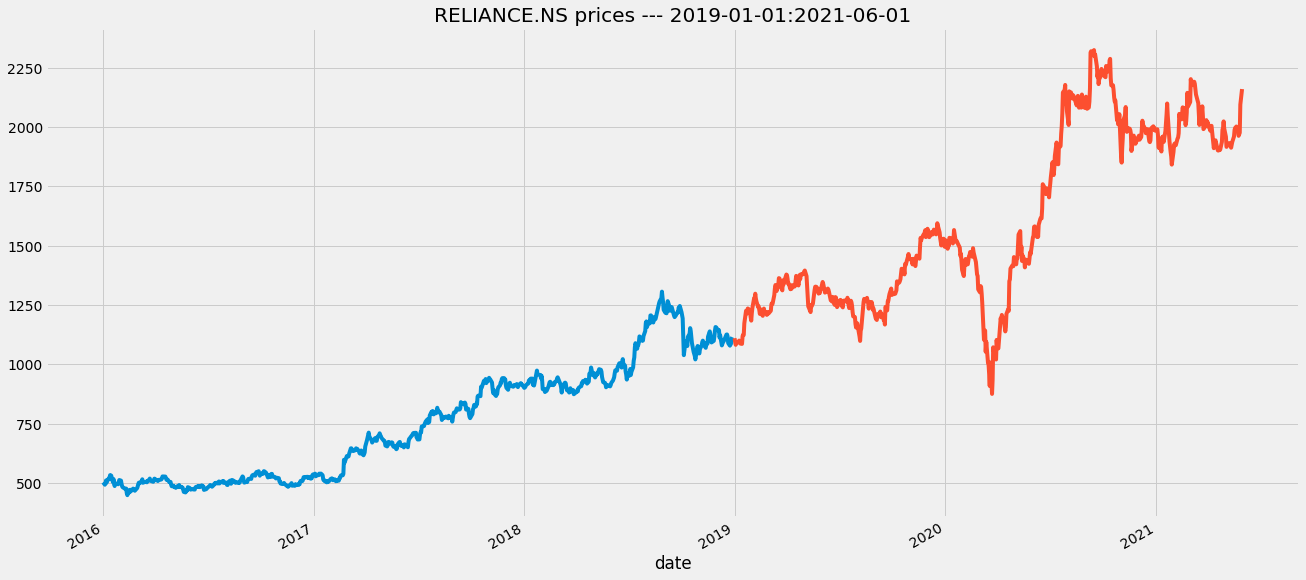

In [95]:
#DOWNLOADING DATA

def download_csv_data(ticker, start_date, end_date, freq, path):
    
    yahoo_financials = YahooFinancials(ticker)

    df = yahoo_financials.get_historical_price_data(start_date, end_date, freq)
    df = pd.DataFrame(df[ticker]['prices']).drop(['date'], axis=1) \
            .rename(columns={'formatted_date':'date'}) \
            .loc[:, ['date','open','high','low','close']] \
            .set_index('date')
    df.index = pd.to_datetime(df.index)
    df = df[(df['close'] > 0)]

    # save data to csv for later ingestion
    df.to_csv(path, header=True, index=True)

    # plot the time series
    df.close.plot(title='{} prices --- {}:{}'.format(ticker, start_date, end_date));
    
#download training data
download_csv_data(ticker='RELIANCE.NS', 
                  start_date='2016-01-01', 
                  end_date='2018-12-31', 
                  freq='daily', 
                  path='RELIANCE_TRAIN.csv')
    
#download test data
# Idea is to use two years data only but since I am calculating 100days SMA, first 100 days will be not taken for test hence the need for extra monthes in the dataset
download_csv_data(ticker='RELIANCE.NS', 
                  start_date='2019-01-01', 
                  end_date='2021-06-01', 
                  freq='daily', 
                  path='RELIANCE_TEST.csv')

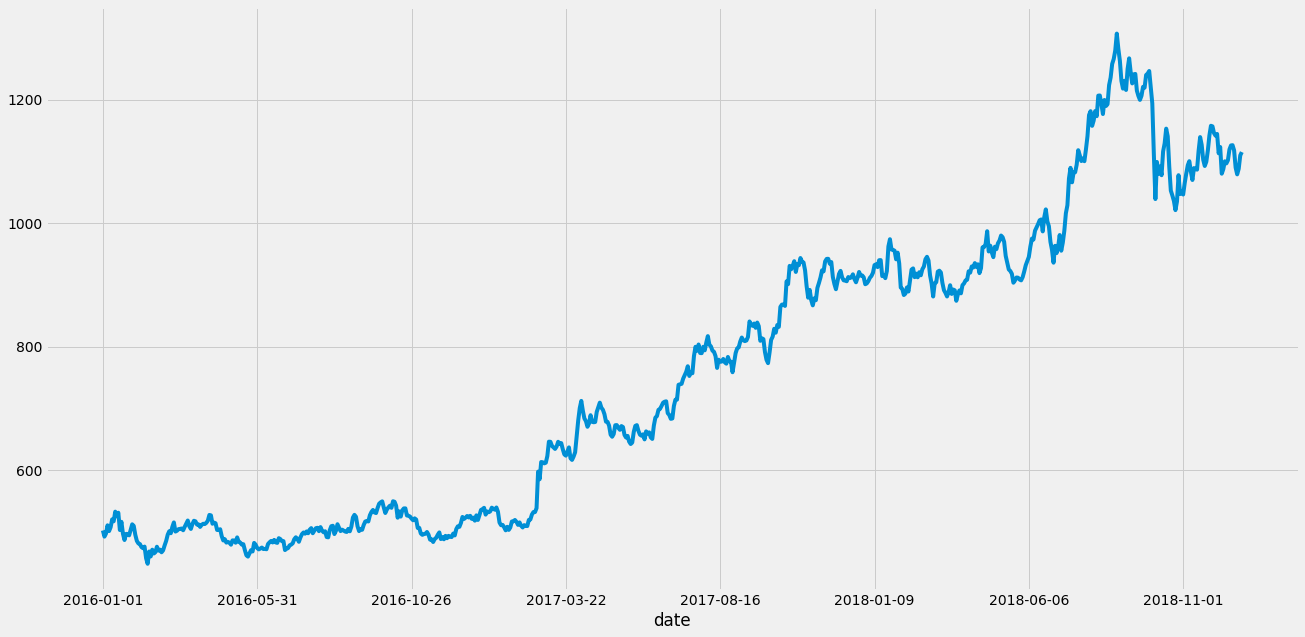

In [96]:
# IMPORTING DATA TO A PANDAS DATAFRAME

pd.options.display.float_format = '{:,.5f}'.format   # Limiting to 5 decimal places
reliance_train = pd.read_csv('RELIANCE_TRAIN.csv').set_index('date')
reliance_train['close'].plot();

In [97]:
#RSI CALCULATION

def get_rsi(close, lookback):
    ret = close.diff()
    up = []
    down = []
    
    # storing up and down series
    for i in range(len(ret)):
        if ret[i] < 0:
            up.append(0)
            down.append(ret[i])
        else:
            up.append(ret[i])
            down.append(0)
    up_series = pd.Series(up)
    down_series = pd.Series(down).abs()
    
    # Use exponential weighted mean
    up_ewm = up_series.ewm(com = lookback - 1, adjust = False).mean()
    down_ewm = down_series.ewm(com = lookback - 1, adjust = False).mean()
    
    #calculate reletive strength
    rs = up_ewm/down_ewm
    
    #normalizing between 0 and 100
    rsi = 100 - (100 / (1 + rs))
    
    #add it to the dataframe
    rsi_df = pd.DataFrame(rsi).rename(columns = {0:'rsi'}).set_index(close.index)
    
    #drop all na values
    rsi_df = rsi_df.dropna()
    
    return rsi_df[3:]

# get 100 days simple moving average
def get_sma100(data, n):
    sma = data.rolling(window = n).mean()
    return pd.DataFrame(sma)


reliance_train['sma100'] = get_sma100(reliance_train['close'], 100)
reliance_train['rsi_14'] = get_rsi(reliance_train['close'], 14)
reliance_train = reliance_train.dropna()
reliance_train

,open,high,low,close,sma100,rsi_14
date,,,,,,
2016-05-30,483.61581,486.14188,477.96933,479.80197,495.11555,47.36689
2016-05-31,479.95056,481.93176,473.75925,474.42789,494.83075,43.72990
2016-06-01,474.47742,478.51416,471.43130,472.32285,494.62421,42.35793
2016-06-02,472.76862,474.08118,468.11276,473.63541,494.38201,43.54724
2016-06-03,475.49280,476.92920,473.43729,475.31946,494.02266,45.11201
...,...,...,...,...,...,...
2018-12-21,"1,114.43628","1,120.62756","1,085.70862","1,089.86914","1,150.00906",43.85528
2018-12-24,"1,090.56250","1,092.84094","1,076.34729","1,078.92285","1,149.75150",41.32436
2018-12-26,"1,075.60437","1,089.67102","1,055.64355","1,088.03650","1,149.62966",44.21115


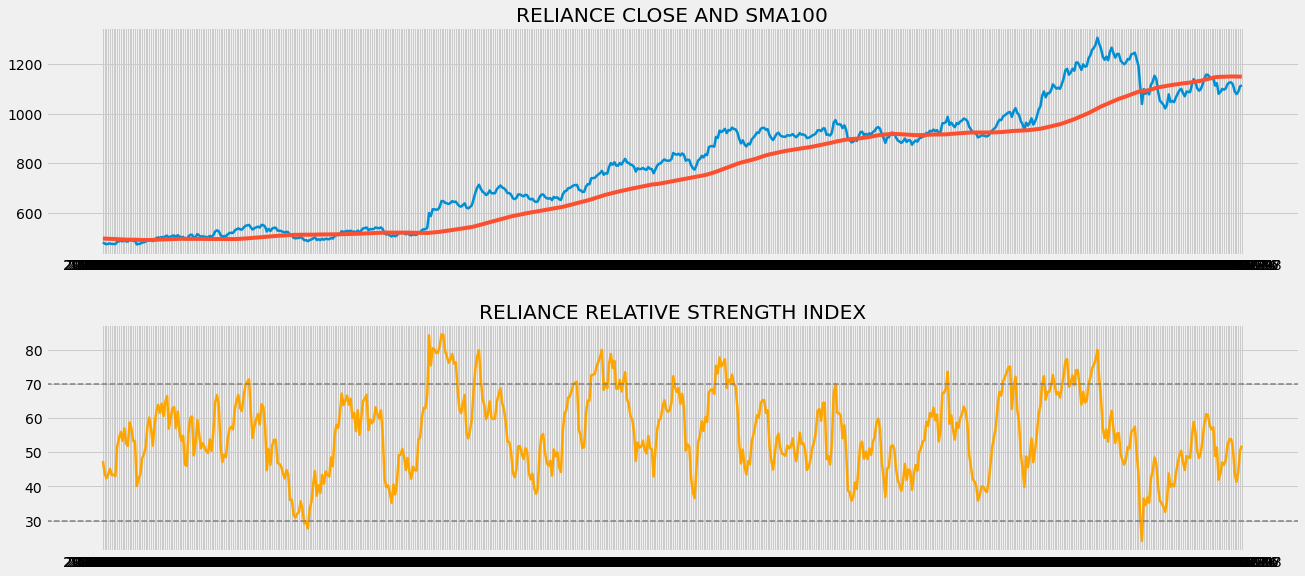

In [98]:
# PLOT CLOSING PRICE, SMA100 and RSI of RELIANCE.NS

ax1 = plt.subplot2grid((10,1), (0,0), rowspan = 4, colspan = 1)
ax2 = plt.subplot2grid((10,1), (5,0), rowspan = 4, colspan = 1)
ax1.plot(reliance_train['close'], linewidth = 2.5)
ax1.plot(reliance_train['sma100'], label = 'SMA 100')
ax1.set_title('RELIANCE CLOSE AND SMA100')
ax2.plot(reliance_train['rsi_14'], color = 'orange', linewidth = 2.5)
ax2.axhline(30, linestyle = '--', linewidth = 1.5, color = 'grey')
ax2.axhline(70, linestyle = '--', linewidth = 1.5, color = 'grey')
ax2.set_title('RELIANCE RELATIVE STRENGTH INDEX')
plt.show()

In [99]:
#TRADING STRATEGY

# buy if rsi crosses 30 from above
# sell if rsi crosses 70 from below

def implement_rsi_strategy(data, prices, rsi):    
    buy_price = []
    buying_dates = []
    selling_dates = []
    sell_price = []
    rsi_signal = []
    signal = 0

    
    for i in range(len(rsi)):
        if rsi[i-1] > 30 and rsi[i] < 30:
            if signal != 1:
                buy_price.append(prices[i])
                buying_dates.append(data.iloc[i+1].name)
                sell_price.append(np.nan)
                signal = 1
                rsi_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                rsi_signal.append(0)
        elif (rsi[i-1] < 70 and rsi[i] > 70):
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(prices[i])
                selling_dates.append(data.iloc[i+1].name)
                signal = -1
                rsi_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                rsi_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            rsi_signal.append(0)
            
    #print(buying_dates, selling_dates)
    
    if (selling_dates[0] < buying_dates[0]):
        buy_price[0] = prices[0]
        buying_dates.insert(0, data.iloc[0].name)
        
    if (selling_dates[-1] < buying_dates[-1]):
        sell_price.pop()
        sell_price.append(prices[-1])
        selling_dates.append(data.iloc[-1].name)
    
    #print(buy_price, sell_price, rsi_signal, buying_dates, selling_dates)
                
    return buy_price, sell_price, rsi_signal, buying_dates, selling_dates
            

buy_price, sell_price, rsi_signal, buying_dates, selling_dates = implement_rsi_strategy(reliance_train, reliance_train['close'], reliance_train['rsi_14'])

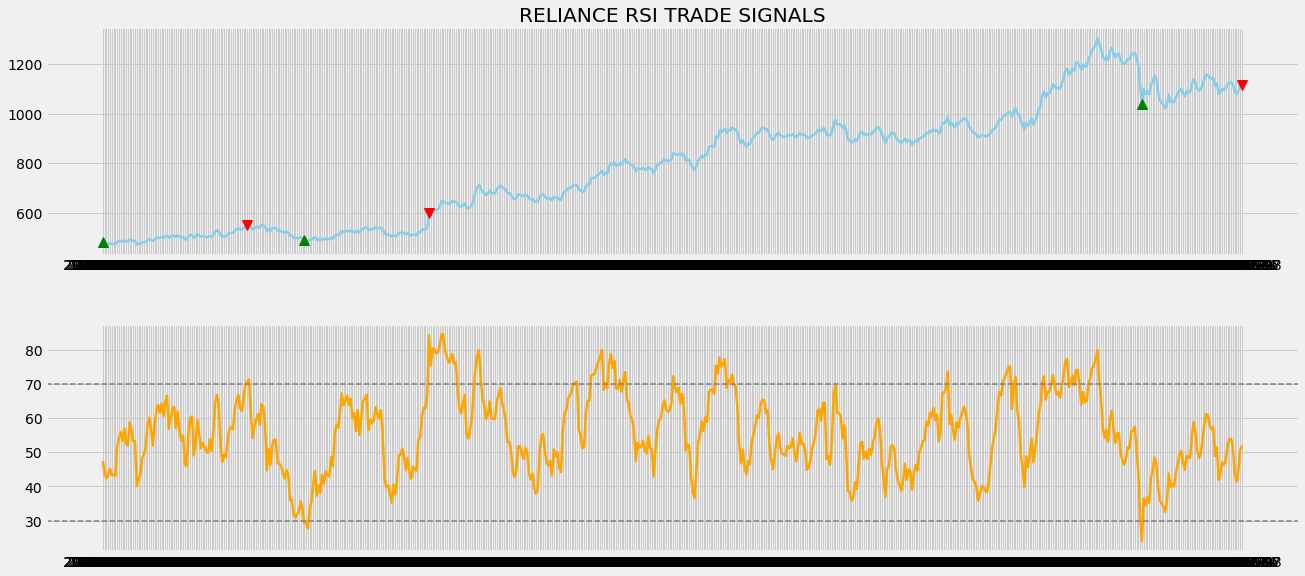

In [100]:
#PLOT SIGNALS

ax1 = plt.subplot2grid((10,1), (0,0), rowspan = 4, colspan = 1)
ax2 = plt.subplot2grid((10,1), (5,0), rowspan = 4, colspan = 1)
ax1.plot(reliance_train['close'], linewidth = 2.5, color = 'skyblue', label = 'RELIANCE')
ax1.plot(reliance_train.index, buy_price, marker = '^', markersize = 10, color = 'green', label = 'BUY SIGNAL')
ax1.plot(reliance_train.index, sell_price, marker = 'v', markersize = 10, color = 'r', label = 'SELL SIGNAL')
ax1.set_title('RELIANCE RSI TRADE SIGNALS')
ax2.plot(reliance_train['rsi_14'], color = 'orange', linewidth = 2.5)
ax2.axhline(30, linestyle = '--', linewidth = 1.5, color = 'grey')
ax2.axhline(70, linestyle = '--', linewidth = 1.5, color = 'grey')
plt.show()

In [101]:
#CREAT OUR POSITION

position = []
for i in range(len(rsi_signal)):
    if rsi_signal[i] > 1:
        position.append(0)
    else:
        position.append(1)
        
for i in range(len(reliance_train['close'])):
    if rsi_signal[i] == 1:
        position[i] = 1
    elif rsi_signal[i] == -1:
        position[i] = 0
    else:
        position[i] = position[i-1]

rsi_signal_df = pd.DataFrame(rsi_signal).rename(columns = {0:'rsi_signal'}).set_index(reliance_train.index)
position_df = pd.DataFrame(position).rename(columns = {0:'rsi_position'}).set_index(reliance_train.index)

frames = [reliance_train, rsi_signal_df, position_df]
reliance_train = pd.concat(frames, join = 'inner', axis = 1)

reliance_train.head()

,open,high,low,close,sma100,rsi_14,rsi_signal,rsi_position
date,,,,,,,,
2016-05-30,483.61581,486.14188,477.96933,479.80197,495.11555,47.36689,0,1
2016-05-31,479.95056,481.93176,473.75925,474.42789,494.83075,43.72990,0,1
2016-06-01,474.47742,478.51416,471.43130,472.32285,494.62421,42.35793,0,1
2016-06-02,472.76862,474.08118,468.11276,473.63541,494.38201,43.54724,0,1
2016-06-03,475.49280,476.92920,473.43729,475.31946,494.02266,45.11201,0,1


In [102]:
# Get the current frame in context which is reliance_train
frame = reliance_train

# Relative profit is calculated as the difference between buying and selling price of the stock
# Also transaction cost of 1% of the total amount is paid during each trade
relative_profits = 0.99*((frame.loc[selling_dates].open.values - frame.loc[buying_dates].open.values)/frame.loc[buying_dates].open.values)
print(relative_profits)

# Calculate on how many trades we win or make profit
wins = [i for i in relative_profits if i > 0]
print(len(wins)/len(relative_profits))

# Our mean profit from all the trades
relative_profits.mean()

# Portfolio value after each trade
portfolio = 100000*(relative_profits + 1).cumprod()

[0.14255833 0.21750152 0.07118568]
1.0


Profit gained from the RSI strategy by investing $100k in RELIANCE : 49009.05125854284
Profit percentage of the RSI strategy : 49.00905125854284%
Benchmark_profit considering the stock as benchmark : 132%


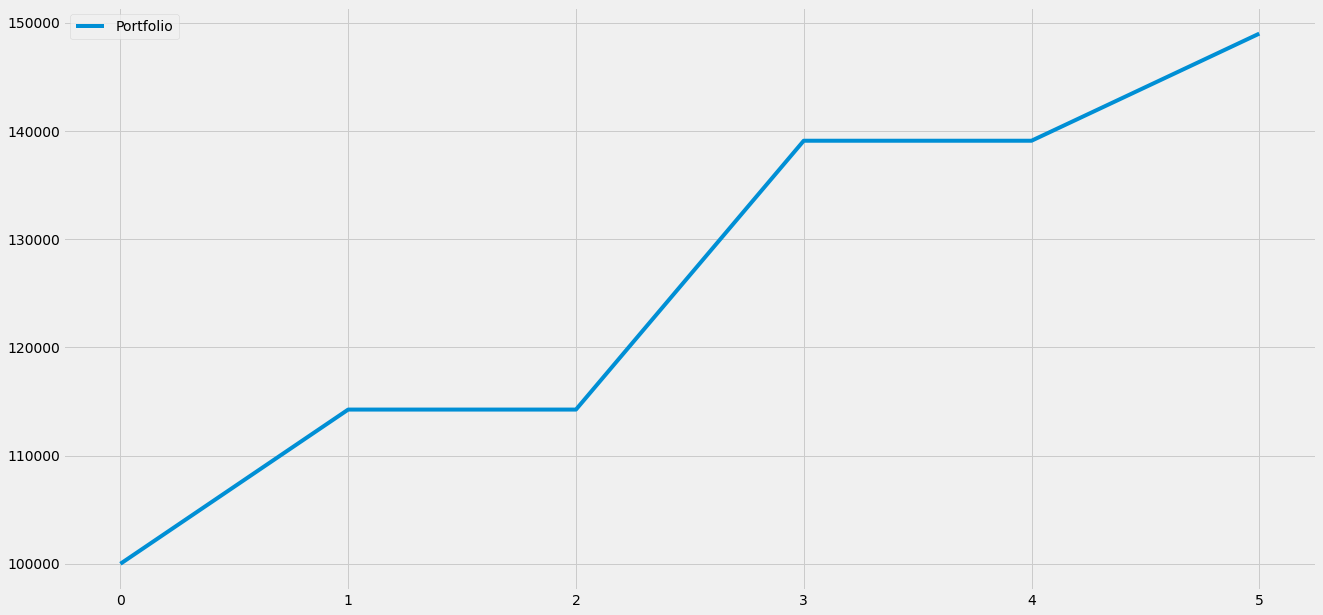

In [103]:
#BACKTESTING THE STRATEGY

# creat an empty dataframe for storing trade information
train_trades = pd.DataFrame(columns=['Trading Days', 'Action', 'Profit', 'Portfolio'])

# We start with ₹100K
initial_investment = 100000

# Now looping through all the trades we build the dataframe
current_portfolio = initial_investment
j =0

for i in range(len(buying_dates)):
    train_trades.loc[j] = [buying_dates[i]] + ["BUY"] + ["-"] + [current_portfolio]
    train_trades.loc[j+1] = [selling_dates[i]] + ["SELL"] + [relative_profits[i]] + [portfolio[i]]
    j+=2
    current_portfolio = portfolio[i]

train_trades.plot()

total_investment_ret = portfolio[-1] - 100000
profit_percentage = total_investment_ret/1000.0
benchmark_profit = floor(100*((reliance_train['close'].iloc[len(reliance_train)-1]/reliance_train['close'].iloc[0])-1))

print(cl('Profit gained from the RSI strategy by investing $100k in RELIANCE : {}'.format(total_investment_ret), attrs = ['bold']))
print(cl('Profit percentage of the RSI strategy : {}%'.format(profit_percentage), attrs = ['bold']))
print(cl('Benchmark_profit considering the stock as benchmark : {}%'.format(benchmark_profit), attrs = ['bold']))

In [104]:
train_trades

,Trading Days,Action,Profit,Portfolio
0,2016-05-30,BUY,-,100000
1,2016-09-27,SELL,0.14256,"114,255.83313"
2,2016-11-16,BUY,-,"114,255.83313"
3,2017-02-23,SELL,0.21750,"139,106.65024"
4,2018-10-08,BUY,-,"139,106.65024"
5,2018-12-28,SELL,0.07119,"149,009.05126"


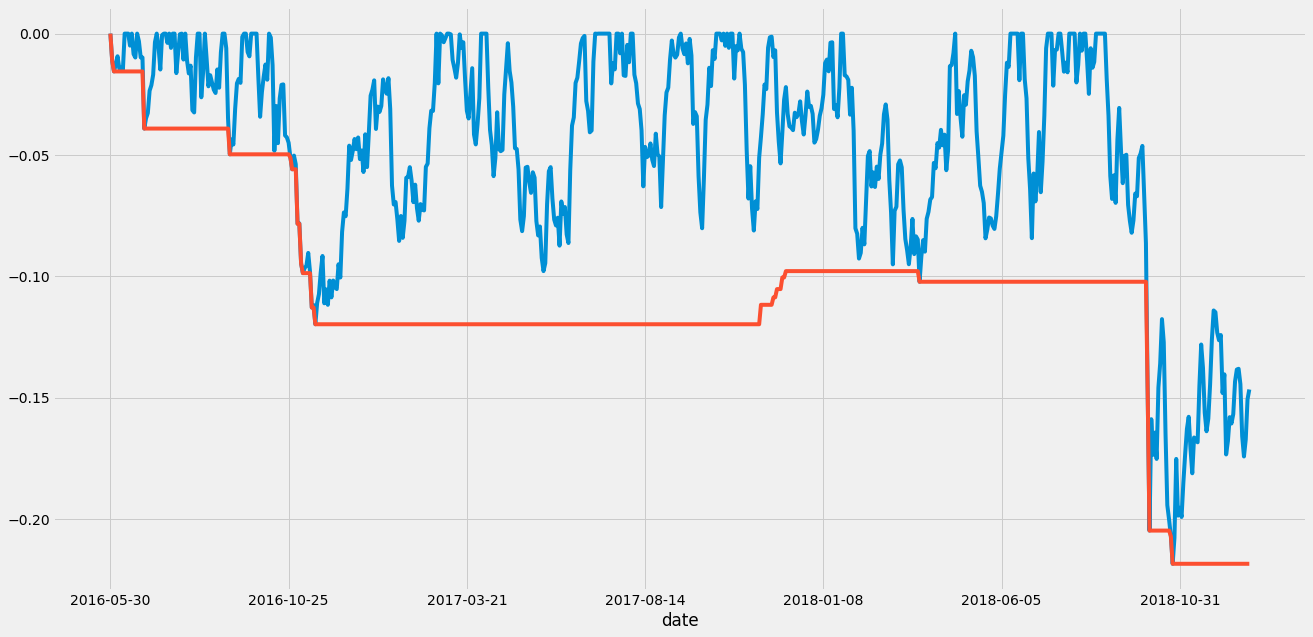

Calculations invloved
Buy Signals generated : 3
Sell Signals generated : 3
Total trades executed : 6
Maximum Drawdown : 21.849888268516548%


In [105]:
#Calculating various parmeters
total_buying_signals = len(buying_dates)
total_selling_signals = len(selling_dates)

window = 250

# Calculate the max drawdown in the past window days for each day in the series. min_periods=1 is used to let the first 252 days data have an expanding window
Roll_Max = reliance_train['close'].rolling(window, min_periods=1).max()
Daily_Drawdown = reliance_train['close']/Roll_Max - 1.0

# Next we calculate the minimum (negative) daily drawdown in that window.
Max_Daily_Drawdown = Daily_Drawdown.rolling(window, min_periods=1).min()

# Plot the results
Daily_Drawdown.plot()
Max_Daily_Drawdown.plot()
plt.show()

maximum_drawdown = abs(Max_Daily_Drawdown.min())*100

print("Calculations invloved")
print(f'Buy Signals generated : {total_buying_signals}')
print(f'Sell Signals generated : {total_selling_signals}')
print(f'Total trades executed : {total_buying_signals + total_selling_signals}')
print(f'Maximum Drawdown : {maximum_drawdown}%')


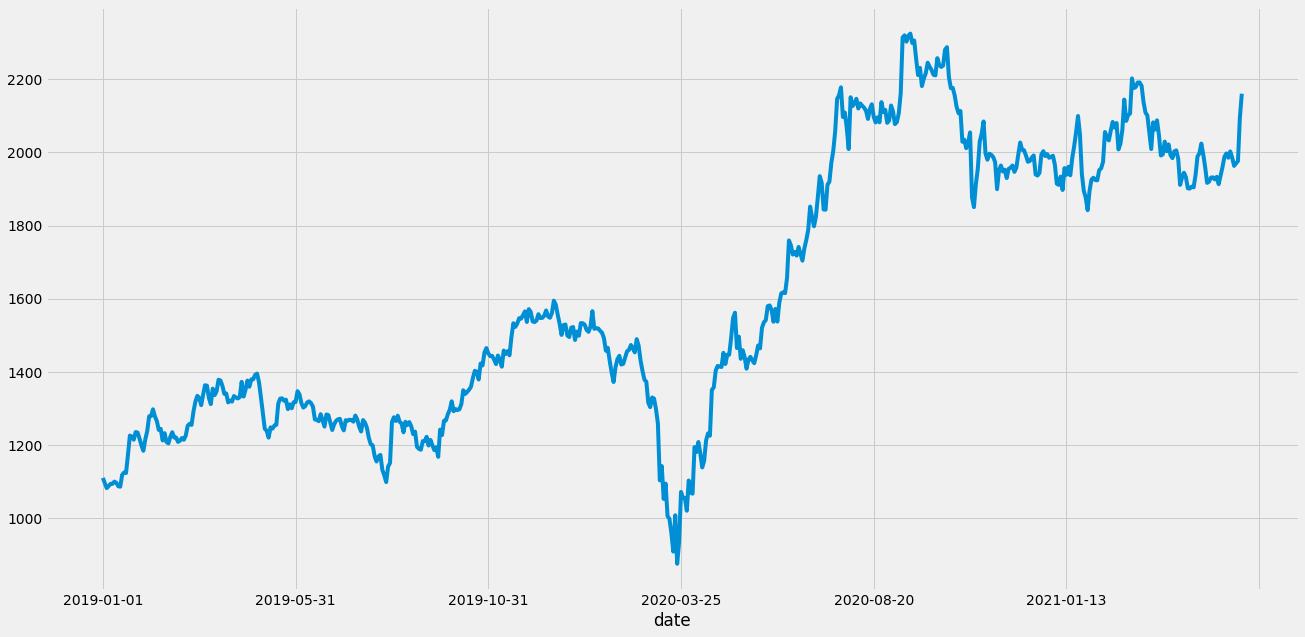

In [106]:
# Now we will move to the testing data
reliance_test = pd.read_csv('RELIANCE_TEST.csv').set_index('date')
reliance_test['close'].plot();

In [107]:
# Calculate Indicators
reliance_test['sma100'] = get_sma100(reliance_test['close'], 100)
reliance_test['rsi_14'] = get_rsi(reliance_test['close'], 20)
reliance_test = reliance_test.dropna()
reliance_test

,open,high,low,close,sma100,rsi_14
date,,,,,,
2019-05-30,"1,303.89038","1,329.39868","1,303.89038","1,317.26367","1,264.46018",51.56683
2019-05-31,"1,325.33716","1,329.29956","1,307.80334","1,317.65991","1,266.53204",51.62740
2019-06-03,"1,322.46436","1,354.41150","1,308.79395","1,347.42773","1,269.04621",55.98034
2019-06-04,"1,344.70361","1,361.34583","1,335.44141","1,338.95801","1,271.61090",54.51118
2019-06-06,"1,349.11182","1,349.11182","1,308.69482","1,314.88623","1,273.87642",50.54286
...,...,...,...,...,...,...
2021-05-25,"1,996.40002","1,997.00000","1,960.00000","1,963.15002","1,999.04851",48.49436
2021-05-26,"1,975.00000","1,979.50000","1,965.30005","1,970.05005","1,998.71601",49.38086
2021-05-27,"1,970.30005","1,993.00000","1,962.25000","1,976.09998","1,998.57651",50.17240


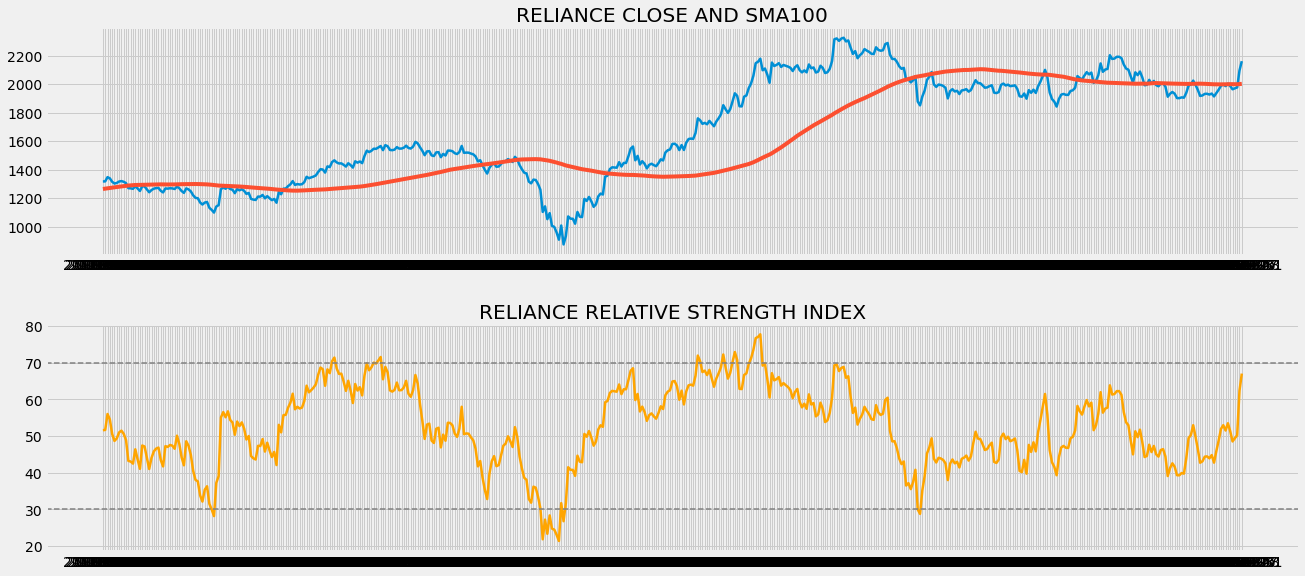

In [108]:
# Plotting 
ax1 = plt.subplot2grid((10,1), (0,0), rowspan = 4, colspan = 1)
ax2 = plt.subplot2grid((10,1), (5,0), rowspan = 4, colspan = 1)
ax1.plot(reliance_test['close'], linewidth = 2.5)
ax1.plot(reliance_test['sma100'], label = 'SMA 100')
ax1.set_title('RELIANCE CLOSE AND SMA100')
ax2.plot(reliance_test['rsi_14'], color = 'orange', linewidth = 2.5)
ax2.axhline(30, linestyle = '--', linewidth = 1.5, color = 'grey')
ax2.axhline(70, linestyle = '--', linewidth = 1.5, color = 'grey')
ax2.set_title('RELIANCE RELATIVE STRENGTH INDEX')
plt.show()

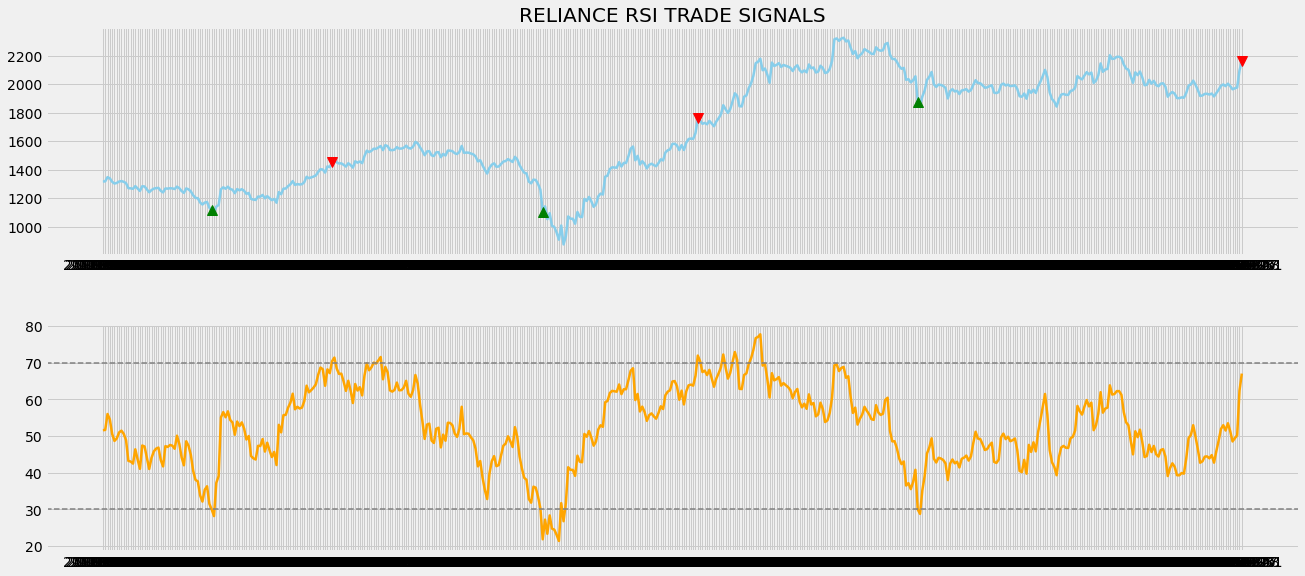

In [109]:
buy_price, sell_price, rsi_signal, buying_dates, selling_dates = implement_rsi_strategy(reliance_test, reliance_test['close'], reliance_test['rsi_14'])

#PLOT SIGNALS

ax1 = plt.subplot2grid((10,1), (0,0), rowspan = 4, colspan = 1)
ax2 = plt.subplot2grid((10,1), (5,0), rowspan = 4, colspan = 1)
ax1.plot(reliance_test['close'], linewidth = 2.5, color = 'skyblue', label = 'RELIANCE')
ax1.plot(reliance_test.index, buy_price, marker = '^', markersize = 10, color = 'green', label = 'BUY SIGNAL')
ax1.plot(reliance_test.index, sell_price, marker = 'v', markersize = 10, color = 'r', label = 'SELL SIGNAL')
ax1.set_title('RELIANCE RSI TRADE SIGNALS')
ax2.plot(reliance_test['rsi_14'], color = 'orange', linewidth = 2.5)
ax2.axhline(30, linestyle = '--', linewidth = 1.5, color = 'grey')
ax2.axhline(70, linestyle = '--', linewidth = 1.5, color = 'grey')
plt.show()

In [110]:
#CREAT OUR POSITION

position = []
for i in range(len(rsi_signal)):
    if rsi_signal[i] > 1:
        position.append(0)
    else:
        position.append(1)
        
for i in range(len(reliance_test['close'])):
    if rsi_signal[i] == 1:
        position[i] = 1
    elif rsi_signal[i] == -1:
        position[i] = 0
    else:
        position[i] = position[i-1]

rsi_signal_df = pd.DataFrame(rsi_signal).rename(columns = {0:'rsi_signal'}).set_index(reliance_test.index)
position_df = pd.DataFrame(position).rename(columns = {0:'rsi_position'}).set_index(reliance_test.index)

frames = [reliance_test, rsi_signal_df, position_df]
reliance_test = pd.concat(frames, join = 'inner', axis = 1)

reliance_test.head()

,open,high,low,close,sma100,rsi_14,rsi_signal,rsi_position
date,,,,,,,,
2019-05-30,"1,303.89038","1,329.39868","1,303.89038","1,317.26367","1,264.46018",51.56683,0,1
2019-05-31,"1,325.33716","1,329.29956","1,307.80334","1,317.65991","1,266.53204",51.62740,0,1
2019-06-03,"1,322.46436","1,354.41150","1,308.79395","1,347.42773","1,269.04621",55.98034,0,1
2019-06-04,"1,344.70361","1,361.34583","1,335.44141","1,338.95801","1,271.61090",54.51118,0,1
2019-06-06,"1,349.11182","1,349.11182","1,308.69482","1,314.88623","1,273.87642",50.54286,0,1


In [111]:
# Get the current frame in context which is reliance_test
frame = reliance_test

# Relative profit is calculated as the difference between buying and selling price of the stock
# Also transaction cost of 1% of the total amount is paid during each trade
relative_profits = 0.99*((frame.loc[selling_dates].open.values - frame.loc[buying_dates].open.values)/frame.loc[buying_dates].open.values)
print(relative_profits)

# Calculate on how many trades we win or make profit
wins = [i for i in relative_profits if i > 0]
print(len(wins)/len(relative_profits))

# Our mean profit from all the trades
relative_profits.mean()

# Portfolio value after each trade
portfolio = 100000*(relative_profits + 1).cumprod()

[0.31066582 0.60955586 0.11104762]
1.0


Profit gained from the RSI strategy by investing $100k in RELIANCE : 134385.47698749846
Profit percentage of the RSI strategy : 134.38547698749846%
Benchmark_profit considering the stock as benchmark : 63%


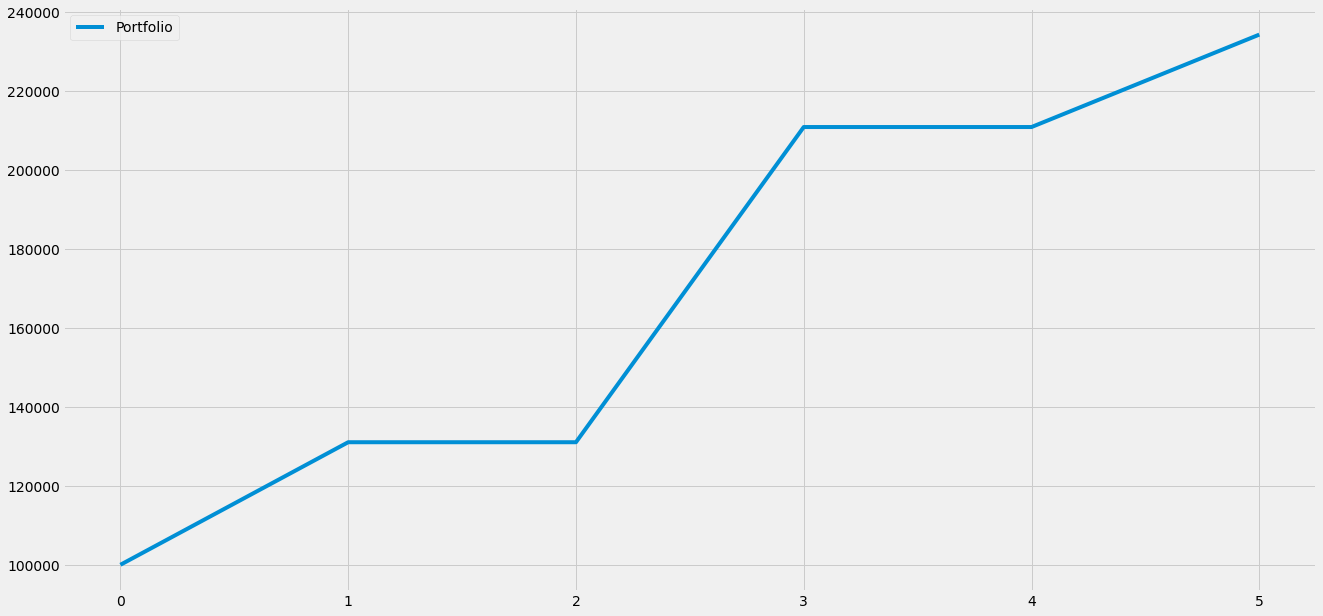

In [112]:
#BACKTESTING THE STRATEGY

# creat an empty dataframe for storing trade information
test_trades = pd.DataFrame(columns=['Trading Days', 'Action', 'Profit', 'Portfolio'])

# We start with ₹100K
initial_investment = 100000

# Now looping through all the trades we build the dataframe
current_portfolio = initial_investment
j =0

for i in range(len(buying_dates)):
    test_trades.loc[j] = [buying_dates[i]] + ["BUY"] + ["-"] + [current_portfolio]
    test_trades.loc[j+1] = [selling_dates[i]] + ["SELL"] + [relative_profits[i]] + [portfolio[i]]
    j+=2
    current_portfolio = portfolio[i]

test_trades.plot()

total_investment_ret = portfolio[-1] - 100000
profit_percentage = total_investment_ret/1000.0
benchmark_profit = floor(100*((reliance_test['close'].iloc[len(reliance_test)-1]/reliance_test['close'].iloc[0])-1))

print(cl('Profit gained from the RSI strategy by investing $100k in RELIANCE : {}'.format(total_investment_ret), attrs = ['bold']))
print(cl('Profit percentage of the RSI strategy : {}%'.format(profit_percentage), attrs = ['bold']))
print(cl('Benchmark_profit considering the stock as benchmark : {}%'.format(benchmark_profit), attrs = ['bold']))

In [113]:
test_trades

,Trading Days,Action,Profit,Portfolio
0,2019-08-07,BUY,-,100000
1,2019-10-30,SELL,0.31067,"131,066.58175"
2,2020-03-11,BUY,-,"131,066.58175"
3,2020-06-22,SELL,0.60956,"210,958.98409"
4,2020-11-03,BUY,-,"210,958.98409"
5,2021-05-31,SELL,0.11105,"234,385.47699"


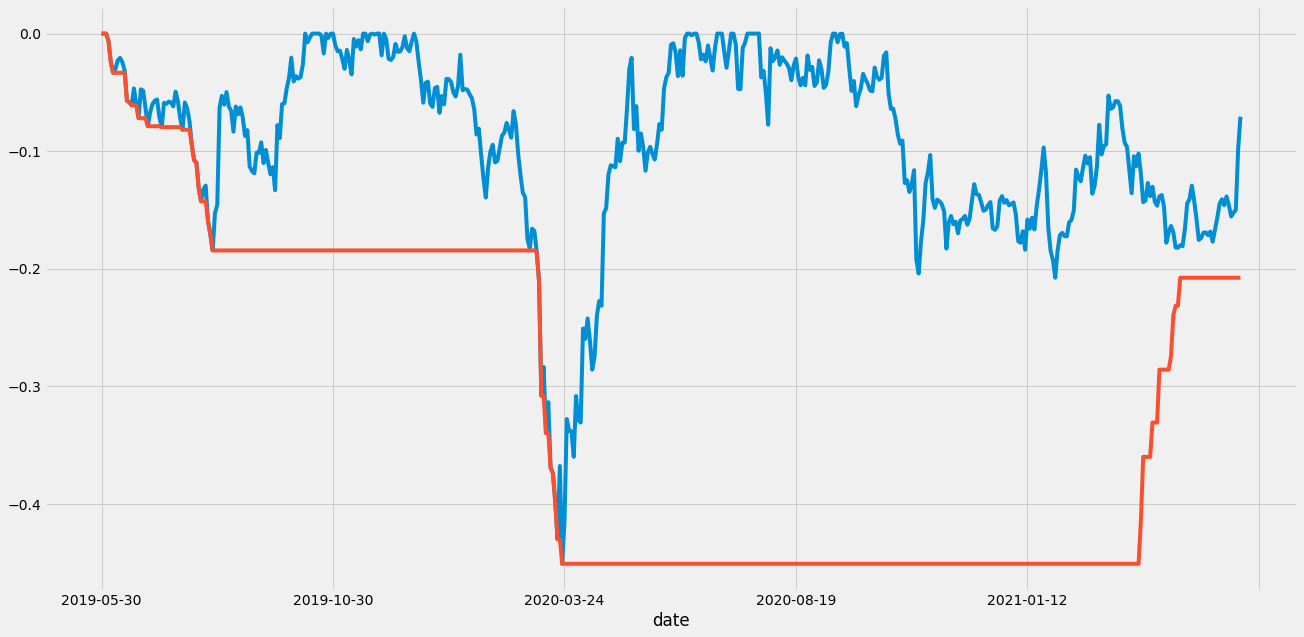

Calculations invloved
Buy Signals generated : 3
Sell Signals generated : 3
Total trades executed : 6
Maximum Drawdown : 45.08835871220752%


In [114]:
#Calculating various parmeters
total_buying_signals = len(buying_dates)
total_selling_signals = len(selling_dates)

window = 250

# Calculate the max drawdown in the past window days for each day in the series. min_periods=1 is used to let the first 252 days data have an expanding window
Roll_Max = reliance_test['close'].rolling(window, min_periods=1).max()
Daily_Drawdown = reliance_test['close']/Roll_Max - 1.0

# Next we calculate the minimum (negative) daily drawdown in that window.
Max_Daily_Drawdown = Daily_Drawdown.rolling(window, min_periods=1).min()

# Plot the results
Daily_Drawdown.plot()
Max_Daily_Drawdown.plot()
plt.show()

maximum_drawdown = abs(Max_Daily_Drawdown.min())*100

print("Calculations invloved")
print(f'Buy Signals generated : {total_buying_signals}')
print(f'Sell Signals generated : {total_selling_signals}')
print(f'Total trades executed : {total_buying_signals + total_selling_signals}')
print(f'Maximum Drawdown : {maximum_drawdown}%')

In [115]:
# Function to create Summary.xlsx
def multiple_dfs(df_list, sheets, file_name, spaces):
    writer = pd.ExcelWriter(file_name,engine='xlsxwriter')   
    row = 0
    for dataframe in df_list:
        dataframe.to_excel(writer,sheet_name=sheets,startrow=row , startcol=0)   
        row = row + len(dataframe.index) + spaces + 1
    writer.save()

# list of dataframes
dfs = [reliance_train, train_trades, reliance_test, test_trades]

# run function
multiple_dfs(dfs, 'Validation', 'Summary.xlsx', 1)